In [ ]:
# 📘 FX Reinforcement Learning System（簡易版）
"""
- 作成者：fxinsightslab
- バージョン：v1.0
- 公開日：2025年4月xx日
- ライセンス：個人利用限定（再配布・商用利用・改変配布禁止）

---

## 📄 利用に関する注意事項

- このノートブックは学習・研究・検証目的で提供されています。
- 実際の売買判断やトレード運用は自己責任の下で行ってください。
- 本テンプレートを改変しての再配布、または第三者への提供・販売は禁止です。

> 💬 ご質問や不具合の報告は、X（旧Twitter）[@fxinsightslab](https://x.com/fxinsightslab) までお気軽にどうぞ！

---

-　このノートの構成と説明はテキストファイルのこの「ノートブックで行われている処理の流れ」
にて説明しておりますので、そちらを確認してください。


✅ 以下のセルから順次実行すると最後の評価まで行えるようになっています。
"""

In [74]:
# データ準備
################################################################
# 指定されたプロジェクトルートからノートブックを実行し、
# MT5からGOLDのM5データを取得・前処理して表示する
################################################################
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import talib
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from sklearn.preprocessing import StandardScaler
import os


# --- プロジェクトルートを自動検出する関数 ---
def find_project_root(target_folder_name="FX Reinforcement Learning System（簡易版）"):
    current_path = os.getcwd() # 現在の作業ディレクトリを取得
    while True:
        # 現在のフォルダ名がターゲット名と一致するか確認
        if os.path.basename(current_path) == target_folder_name:
            return current_path # 一致すればそのパスを返す
        parent = os.path.dirname(current_path)# 一つ上の階層へ移動
        if parent == current_path:
            # ルートまで探索しても見つからなければエラーを投げる
            raise FileNotFoundError(f"{target_folder_name} フォルダが上位ディレクトリに見つかりませんでした。")
        current_path = parent# 次のループでは上位フォルダを探索

try:# プロジェクトルートのパスを取得し、指定ノートブックを実行
    base_path = find_project_root()  
    target_path = os.path.join(base_path, "src/utils/data_preparation.ipynb").replace("\\", "/")
    %run "$target_path"# ノートブックを実行して関数などを読み込み
except FileNotFoundError as e:
    print(e)# 見つからなければエラーメッセージを表示


# --- MT5からデータ取得 ---
mt5.initialize()  # MT5との接続を初期化
symbol = "GOLD"  # 取得する銘柄を指定
# GOLDの5分足データを「現在の最新の足」から遡って1000本取得
rates = mt5.copy_rates_from_pos(symbol, mt5.TIMEFRAME_M5, 0, 10000)  # 0 は「現在時刻に最も近いバー（=最新バー）を起点」という意味
mt5.shutdown()  # MT5との接続を終了

# --- データフレームに変換・整形 ---
df = pd.DataFrame(rates)  # MT5データをDataFrame形式に変換
df["time"] = pd.to_datetime(df["time"], unit="s")  # UNIX時間を日時形式に変換

# --- 前処理実行（data_preparation.ipynbで定義された関数） ---
df = prepare_data(df)  # 指定関数でテクニカル指標などを追加・整形

# --- 結果表示（先頭5行） ---
print(df.head())  # データの先頭を表示して確認

                  time      open      high       low     close  tick_volume  \
49 2025-03-06 05:15:00 -1.212912 -1.215784 -1.208686 -1.215906          408   
50 2025-03-06 05:20:00 -1.216092 -1.221993 -1.213573 -1.215229          287   
51 2025-03-06 05:25:00 -1.214603 -1.211802 -1.209026 -1.215162          554   
52 2025-03-06 05:30:00 -1.214671 -1.218551 -1.210451 -1.217801          281   
53 2025-03-06 05:35:00 -1.217378 -1.222398 -1.220156 -1.226665          235   

    spread  real_volume    volume  raw_close    SMA_20    EMA_50    RSI_14  \
49      27            0 -0.797033    2922.82 -1.206994 -1.228437 -0.023265   
50      29            0 -1.071590    2922.92 -1.206869 -1.227771  0.019663   
51      27            0 -0.465749    2922.93 -1.206872 -1.227128  0.024231   
52      27            0 -1.085205    2922.54 -1.207745 -1.226614 -0.176894   
53      30            0 -1.189582    2921.23 -1.208845 -1.226469 -0.771147   

        MACD    ATR_14  BB_upper  BB_lower       OBV  zi

In [75]:
# --- トレンド分析用の強化学習環境クラス（13特徴量 + 実価格ベースの取引ロジック） ---
################################################################
#✅ このクラスの主な特徴：

# 13特徴量（価格、テクニカル指標）を観測空間に設定。

# raw_closeを使った実価格ベースの損益計算。

# 最大保有期間を超えると自動決済。

# ポジション切り替え時のPNL精算＆再エントリー。

# 取引コストや保留ペナルティを含めた報酬設計。
################################################################
class TrendEnv(gym.Env):
    def __init__(self, data):
        super(TrendEnv, self).__init__()
        self.data = data.reset_index(drop=True)  # データのインデックスをリセット
        self.current_step = 0  # 現在のステップ（データ行）を初期化
        self.max_steps = len(data) - 1  # 最大ステップ数をデータの長さに基づき設定
        self.position = None  # 現在のポジション状態（None, "long", "short"）
        self.entry_price = 0  # エントリー価格（ポジションを取った価格）

        # --- 状態空間（13特徴量ベクトル）---
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(13,), dtype=np.float32
        )

        # --- 行動空間（0: 保留, 1: 買い, 2: 売り）---
        self.action_space = spaces.Discrete(3)

    # --- 現在のステップにおける状態（テクニカル特徴量）を取得 ---
    def _get_state(self):
        row = self.data.iloc[self.current_step]
        return np.array([
            row["close"],
            row["SMA_20"],
            row["RSI_14"],
            row["MACD"],
            row["ATR_14"],
            row["BB_upper"],
            row["BB_lower"],
            row["volume"],
            row["open"],
            row["high"],
            row["low"],
            row["EMA_50"],
            row["OBV"]
        ], dtype=np.float32)

    # --- 環境の初期化（エピソードの開始）---
    def reset(self, seed=None):
        self.current_step = 0
        self.position = None
        self.entry_price = 0
        return self._get_state(), {}

    # --- 1ステップ進めて行動に応じた報酬を計算 ---
    def step(self, action):
        reward = 0.0
        terminated = False
        truncated = False
        current_price = self.data["raw_close"].iloc[self.current_step]  # ✅ 実際の終値（非加工）を使用
        TRADING_COST = 0.4  # 取引手数料
        MAX_HOLD = 50  # 最大保有ステップ数（超えたら強制決済）

        # --- 保留（action == 0）---
        if action == 0:
            reward -= 0.05  # 保留ペナルティ
            # ロング・ショート時は含み益に応じて微報酬
            if self.position == "long":
                unrealized = current_price - self.entry_price
                reward += max(unrealized * 0.05, 0)
            elif self.position == "short":
                unrealized = self.entry_price - current_price
                reward += max(unrealized * 0.05, 0)

        # --- 買い（action == 1）---
        elif action == 1:
            if self.position is None:
                # 新規ロングエントリー
                self.position = "long"
                self.entry_price = current_price
                self.hold_steps = 0
                reward -= TRADING_COST
            elif self.position == "short":
                # ショートポジション決済 → ロング転換
                pnl = self.entry_price - current_price
                reward += pnl - TRADING_COST
                self.position = "long"
                self.entry_price = current_price
                self.hold_steps = 0

        # --- 売り（action == 2）---
        elif action == 2:
            if self.position is None:
                # 新規ショートエントリー
                self.position = "short"
                self.entry_price = current_price
                self.hold_steps = 0
                reward -= TRADING_COST
            elif self.position == "long":
                # ロングポジション決済 → ショート転換
                pnl = current_price - self.entry_price
                reward += pnl - TRADING_COST
                self.position = "short"
                self.entry_price = current_price
                self.hold_steps = 0

        # --- 保有ポジションのホールド制御 ---
        if self.position:
            self.hold_steps += 1
            if self.hold_steps >= MAX_HOLD:
                # MAX_HOLD に達したら強制決済
                if self.position == "long":
                    reward += current_price - self.entry_price
                elif self.position == "short":
                    reward += self.entry_price - current_price
                self.position = None
                self.entry_price = 0
                self.hold_steps = 0

        # --- 次のステップへ進む ---
        self.current_step += 1
        if self.current_step >= self.max_steps:
            terminated = True  # 終了条件（データ末尾到達）
            last_price = self.data["raw_close"].iloc[self.current_step - 1]
            if self.position == "long":
                reward += last_price - self.entry_price - TRADING_COST
            elif self.position == "short":
                reward += self.entry_price - last_price - TRADING_COST

        # --- 新しい状態・報酬・終了フラグを返す ---
        return self._get_state(), reward, terminated, truncated, {}


In [80]:
# ========== ② 環境＆学習設定 ==========
################################################################
# load_or_create_model() により学習済みモデルの再利用 or 上書きが簡単に切り替え可能。
################################################################

import os
from stable_baselines3 import PPO

# --- モデルの読み込み or 新規作成を行う関数 ---
def load_or_create_model(env, model_name="trend_ai_ppo", force_new=False, verbose=1):
    """
    モデルの読み込み or 新規作成

    Parameters:
        env: 強化学習環境（Monitor付き）
        model_name: モデルの保存ファイル名（拡張子なし）
        force_new: Trueなら既存モデルを無視して新規作成
        verbose: PPOの出力詳細レベル

    Returns:
        PPOモデルインスタンス
    """
    base_path = find_project_root()  # プロジェクトルートパスを取得
    model_path = os.path.join(base_path, f"src/agents/models/{model_name}.zip")  # モデルファイルパスを生成

    # 既存モデルがあり、再学習指示でなければロード
    if os.path.exists(model_path) and not force_new:
        print(f"✅ 既存モデル '{model_name}' を読み込みます。")
        model = PPO.load(model_path)
        model.set_env(env)  # 環境を再設定（再学習時に必要）
    else:
        # 既存ファイルがあっても force_new = True の場合は上書き
        if os.path.exists(model_path):
            print(f"🆕 モデル '{model_name}' を上書きして新規学習します。")
        else:
            print(f"🆕 モデル '{model_name}' が存在しないため、新規に作成します。")
        model = PPO("MlpPolicy", env, verbose=verbose)  # 新規モデル作成

    return model

# --- 必要な補助ツールのインポート ---
from stable_baselines3.common.monitor import Monitor  # ログ記録用ラッパー
from stable_baselines3.common.env_checker import check_env  # 環境構成の妥当性チェック

# --- 環境の初期化 ---
env = TrendEnv(df)          # トレンド分析用の環境を構築
check_env(env)              # Gym互換チェック（デバッグ用）
monitored_env = Monitor(env)  # モニター付き環境で学習ログ等を記録

# --- 学習設定（force_train=Trueで新規学習を強制）---
force_train = False # ← Trueなら新規に学習を始める、Falseなら保存済みモデルを再利用

# --- モデル取得（ロード or 新規作成）---
model = load_or_create_model(monitored_env, model_name="trend_ai_ppo", force_new=force_train)

# --- モデルの学習実行 ---
model.learn(total_timesteps=100000)  # 総学習ステップ数を指定（例：10000）

# --- モデルの保存（自動で .zip 拡張子が付加される）---
model.save("models/trend_ai_ppo")
print("✅ 学習完了・モデル保存済み")

✅ 既存モデル 'trend_ai_ppo' を読み込みます。
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 1323 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 681          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0015608186 |
|    clip_fraction        | 0.0208       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.126       |
|    explained_variance   | 0.577        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.9         |
|    n_updates            | 990          |
|    policy_gradient_loss | -0.000323    |
|    value_loss           | 15.3   

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | 341          |
| time/                   |              |
|    fps                  | 389          |
|    iterations           | 12           |
|    time_elapsed         | 63           |
|    total_timesteps      | 24576        |
| train/                  |              |
|    approx_kl            | 0.0013297305 |
|    clip_fraction        | 0.0261       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.181       |
|    explained_variance   | 0.405        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.1         |
|    n_updates            | 1090         |
|    policy_gradient_loss | 0.000181     |
|    value_loss           | 19.9         |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | 348         |
| time/                   |             |
|    fps                  | 380         |
|    iterations           | 22          |
|    time_elapsed         | 118         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.003853364 |
|    clip_fraction        | 0.0412      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.241      |
|    explained_variance   | 0.376       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.72        |
|    n_updates            | 1190        |
|    policy_gradient_loss | -0.000394   |
|    value_loss           | 12.1        |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95e+03    |
|    ep_rew_mean          | 305         |
| time/                   |             |
|    fps                  | 377         |
|    iterations           | 32          |
|    time_elapsed         | 173         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.004425894 |
|    clip_fraction        | 0.0269      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.24       |
|    explained_variance   | 0.432       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.85        |
|    n_updates            | 1290        |
|    policy_gradient_loss | 0.000536    |
|    value_loss           | 11.3        |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95e+03     |
|    ep_rew_mean          | 315          |
| time/                   |              |
|    fps                  | 374          |
|    iterations           | 42           |
|    time_elapsed         | 229          |
|    total_timesteps      | 86016        |
| train/                  |              |
|    approx_kl            | 0.0030762968 |
|    clip_fraction        | 0.0389       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.227       |
|    explained_variance   | 0.45         |
|    learning_rate        | 0.0003       |
|    loss                 | 4.61         |
|    n_updates            | 1390         |
|    policy_gradient_loss | -0.00164     |
|    value_loss           | 9.21         |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

In [60]:
# モデル読み込み＆確認処理
import os
from stable_baselines3 import PPO
import zipfile

################################################################
# find_project_root()	上位ディレクトリから "FX Reinforcement Learning System（簡易版）" を探索
# os.path.exists()	モデルファイルの存在確認（trend_ai_ppo.zip）
# PPO.load()	学習済みモデルの読み込み（stable-baselines3）
# zipfile.ZipFile	.zip の中に含まれるファイルを列挙表示
################################################################

# --- モデルの読み込み処理(find_project_rootを使用) ---
try:
    base_path = find_project_root()  # プロジェクトルートを自動検出
    model_path = os.path.join(base_path, "src/agents/models/trend_ai_ppo.zip")  # モデルのファイルパスを指定

    if os.path.exists(model_path):
        print("✅ モデルファイルが見つかりました:", model_path)

        try:
            # --- モデルの読み込みを試みる ---
            model = PPO.load(model_path)
            print("✅ モデルの読み込みに成功しました！")

            # --- zipファイルの内容確認（中身をリスト表示）---
            with zipfile.ZipFile(model_path, 'r') as zip_ref:
                print("📦 含まれるファイル一覧:")
                for name in zip_ref.namelist():
                    print("  -", name)

        except Exception as e:
            # モデルファイルが壊れている・依存関係が合わない等の可能性
            print("❌ モデルの読み込みに失敗しました:", e)
    else:
        print("❌ モデルファイルが存在しません:", model_path)

except FileNotFoundError as e:
    # プロジェクトルートが見つからなかった場合のエラー処理
    print("❌ エラー:", e)

✅ モデルファイルが見つかりました: C:\Users\kotak\FX Reinforcement Learning System（簡易版）\src/agents/models/trend_ai_ppo.zip
✅ モデルの読み込みに成功しました！
📦 含まれるファイル一覧:
  - data
  - pytorch_variables.pth
  - policy.pth
  - policy.optimizer.pth
  - _stable_baselines3_version
  - system_info.txt


In [81]:
################################################################
# capital	初期資金をシミュレート。トレードによって増減
# action == 1/2	ロング（買い）／ショート（売り）
# position	現在の保有状態を記録（ポジション管理）
# equity_curve	毎ステップの資産額を記録し、可視化に活用可能
# Counter(actions)	モデルが各行動をどれだけ取ったかを集計表示
################################################################

# ========== ③ 評価フェーズ ==========

def evaluate_model(model, env, steps=200):
    obs, _ = env.reset()  # 環境を初期化し、最初の観測を取得
    total_reward = 0  # 累積報酬
    actions = []  # 行動履歴
    rewards = []  # 各ステップの報酬
    equity_curve = []  # 資産曲線（毎ステップの資産）

    capital = 10000  # 評価開始時の仮想資金
    position = None  # 現在のポジション（"long", "short", None）
    entry_price = None  # エントリー価格の記録
    prices = env.data["raw_close"].values  # ❗ 実際の価格を使用（スケーリングなし）

    for step in range(steps):
        # --- モデルから行動を決定（確定的に） ---
        action, _ = model.predict(obs, deterministic=True)
        action = int(action)
        obs, reward, done, truncated, _ = env.step(action)

        price = prices[env.current_step]  # 現在の実価格（raw_close）

        # --- 資産変動のシミュレーションロジック ---
        if position is None:
            # 未保有 → ロングまたはショートの新規建て
            if action == 1:
                position = "long"
                entry_price = price
            elif action == 2:
                position = "short"
                entry_price = price

        elif position == "long":
            # ロング中 → ショートで決済＆建て直し
            if action == 2:
                capital += price - entry_price
                position = "short"
                entry_price = price
            elif action == 0:
                pass  # 保留中は何もしない

        elif position == "short":
            # ショート中 → ロングで決済＆建て直し
            if action == 1:
                capital += entry_price - price
                position = "long"
                entry_price = price
            elif action == 0:
                pass

        # --- ログ記録 ---
        equity_curve.append(capital)
        actions.append(action)
        rewards.append(reward)
        total_reward += reward

        # --- 終了条件チェック（done: episode終了, truncated: max steps到達） ---
        if done or truncated:
            break

    # --- 評価結果の表示 ---
    print(f"📊 評価結果")
    print(f"・合計報酬: {total_reward:.2f}")
    from collections import Counter
    print("・行動内訳:", Counter(actions))
    print(f"・最終資産: {capital:.2f}")

    return actions, rewards, equity_curve  # 行動履歴・報酬履歴・資産曲線を返す

# --- モデル評価実行（200ステップ） ---
actions, rewards, equity_curve = evaluate_model(model, TrendEnv(df), steps=200)


📊 評価結果
・合計報酬: -2.67
・行動内訳: Counter({1: 186, 0: 14})
・最終資産: 10000.00


                  time      open      high       low     close  tick_volume  \
49 2025-04-22 19:35:00  2.346070  2.337719  1.841320  1.893262         2061   
50 2025-04-22 19:40:00  1.884207  2.051706  1.813083  2.130616         1970   
51 2025-04-22 19:45:00  2.126284  2.193321  2.146352  2.214613         1755   
52 2025-04-22 19:50:00  2.215801  2.135213  2.185048  2.139329         1440   
53 2025-04-22 19:55:00  2.136037  2.413223  2.226183  2.459287         1382   

    spread  real_volume    volume  raw_close    SMA_20    EMA_50    RSI_14  \
49      27            0  2.669332    3376.86  3.120751  3.364286 -1.763858   
50      27            0  2.468592    3383.67  3.042639  3.309358 -1.309677   
51      27            0  1.994316    3386.08  2.982735  3.259804 -1.154919   
52      27            0  1.299446    3383.92  2.909796  3.209307 -1.228091   
53      27            0  1.171502    3393.10  2.856714  3.173052 -0.646479   

        MACD    ATR_14  BB_upper  BB_lower       OBV  
4

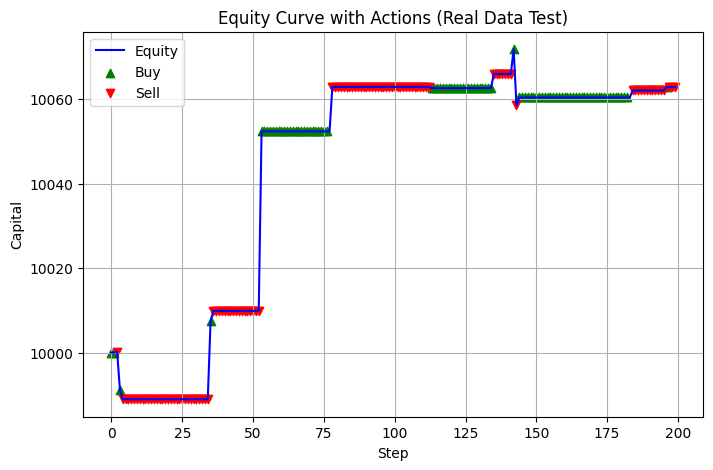

In [82]:
# ========== リアルデータテスト ==========

# --- MT5に接続してGOLDの最新5分足を1000本取得 ---
mt5.initialize()
symbol = "GOLD"
rates = mt5.copy_rates_from_pos(symbol, mt5.TIMEFRAME_M5, 0, 1000)
mt5.shutdown()

# --- DataFrame形式に変換 ---
test_df = pd.DataFrame(rates)
test_df["time"] = pd.to_datetime(test_df["time"], unit="s")  # UNIX秒を日付に変換
test_df["volume"] = test_df["tick_volume"]  # 実質的な出来高列に変換

# ✅ スケーリング前の終値（raw_close）を保持（資産計算用）
test_df["raw_close"] = test_df["close"]

# --- テクニカル指標を再計算（PPO学習時と同じ13指標） ---
test_df["SMA_20"] = talib.SMA(test_df["close"], timeperiod=20)
test_df["EMA_50"] = talib.EMA(test_df["close"], timeperiod=50)
test_df["RSI_14"] = talib.RSI(test_df["close"], timeperiod=14)
macd, _, _ = talib.MACD(test_df["close"])
test_df["MACD"] = macd
test_df["ATR_14"] = talib.ATR(test_df["high"], test_df["low"], test_df["close"])
upper, _, lower = talib.BBANDS(test_df["close"])
test_df["BB_upper"] = upper
test_df["BB_lower"] = lower
test_df["OBV"] = talib.OBV(test_df["close"], test_df["volume"])

# 欠損値を削除（移動平均やMACDなどの初期値）
test_df = test_df.dropna()

# --- スケーリング（raw_close以外の特徴量を正規化）---
features = [
    "close", "SMA_20", "RSI_14", "MACD", "ATR_14", 
    "BB_upper", "BB_lower", "volume", "open", "high", "low", "EMA_50", "OBV"
]
scaler = StandardScaler()
test_df[features] = scaler.fit_transform(test_df[features])

# --- 環境を構築し、モデルで評価実施 ---
test_env = TrendEnv(test_df)
model = model  # （すでにロード・学習済みのモデル）

print(test_df.head())  # データ確認（テスト用）

# --- 評価実行（200ステップ） ---
actions, rewards, equity_curve = evaluate_model(model, test_env, steps=200)

# --- 資産曲線＋行動マーカーを可視化する関数 ---
import matplotlib.pyplot as plt

def plot_equity_with_actions(equity_curve, actions):
    buy_points = []
    sell_points = []

    # 行動ログから買い/売り位置を抽出
    for i, action in enumerate(actions):
        if action == 1:
            buy_points.append(i)
        elif action == 2:
            sell_points.append(i)

    # --- グラフ描画 ---
    plt.figure(figsize=(8, 5))
    plt.plot(equity_curve, label="Equity", color="blue")  # 資産曲線
    plt.scatter(buy_points, [equity_curve[i] for i in buy_points], color='green', marker='^', label="Buy")
    plt.scatter(sell_points, [equity_curve[i] for i in sell_points], color='red', marker='v', label="Sell")

    plt.title("Equity Curve with Actions (Real Data Test)")
    plt.xlabel("Step")
    plt.ylabel("Capital")
    plt.legend()
    plt.grid()
    plt.show()

# --- 描画実行 ---
plot_equity_with_actions(equity_curve, actions)
